<a href="https://colab.research.google.com/github/frex1/tensorflow/blob/master/freeman1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mounting google drive where the data files are stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Since this is high computation, gpu is required and having changed runtime from localhost to GPU hardware accelerator, it's wise to confirm the set up.
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#Silence Warnings to keep the notebook tidy
import warnings
warnings.simplefilter("ignore")

# Data Preparation

In [0]:
# Import relevant libraries
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from tqdm import tqdm
import pandas_profiling
from glob import glob
from PIL import Image
import os
from keras import backend as K

In [0]:
#Default Working Directory
os.getcwd()

'/content'

In [0]:
#Unzip image and csv folders unless if you imported them in already unzipped format which is less likely. Choose one destination directory for all the unzipped files.
#!unzip -uq "/content/drive/My Drive/HAM10000_images_part_1.zip" -d "/content/drive/My Drive/Colab/images"
#!unzip -uq "/content/drive/My Drive/PROJECT/HAM10000_images_part_2.zip" -d "/content/drive/My Drive/Colab/images"

In [0]:
#Printing the content of the input directory to confirm that your files are in place
print(os.listdir("/content/drive/My Drive/PROJECT"))

['HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2']


In [0]:
#Set path to input files and create dictionaries for image path and name, and for lesion_type abbreviation and full description
input='/content/drive/My Drive/PROJECT'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(input, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Two dictionaries were created; first, glob was used to get the path of each image and a dict of image name and path was created. Another for abbreviated lesion_types and their full names was created and later assigned as new variables to the dataframe.

In [0]:
#Reading metadata file
skin_df=pd.read_csv(os.path.join(input, 'HAM10000_metadata.csv'))

In [0]:
# Using the dictionaries created above to create new variable "path", "cell_type" and "cell_type_idx"
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# Data Exploration

In [0]:
# First 5 rows
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2


In [0]:
# Shape
skin_df.shape

(10015, 10)

In [0]:
#General descriptive statistics excluding null values
skin_df.describe(exclude=np.number)

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0005263,ISIC_0030386,nv,histo,male,back,/content/drive/My Drive/PROJECT/HAM10000_image...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [0]:
#Missing values
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

There are 57 missing values in the age column. However, this has nothing to do with the model we are going to build here, since we are using images. So we won't be concerned about handling the milling values.

In [0]:
#Descriptive Statistics of age
skin_df.age.describe()

count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

Boxplot of Age


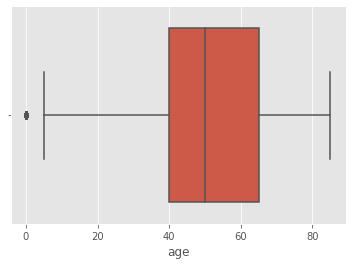

In [0]:
#Boxplot for age distribution
print("Boxplot of Age")
sns.boxplot(x=skin_df['age'])

Histgram of Age


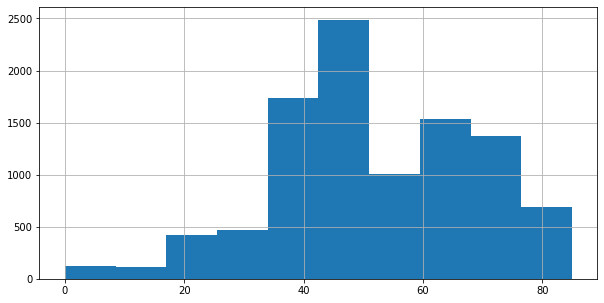

In [0]:
#Histogram for age distribution
print("Histgram of Age")
skin_df['age'].hist(bins=10, figsize=(10,5))
plt.show()

In [0]:
#Create age groups segments based on the descriptive statistics seen earlier
#set up bins
bin = [0,40,50,65,85]
label = ['Young', 'Middle', 'Advanced', 'Old']
#use pd.cut function can attribute the values into its specific bins
age_group = pd.cut(skin_df.age,bins=bin, labels=label)
age_group = age_group.to_frame()
age_group.columns = ['age_category']
#concatenate age and its bin
df_new = pd.concat([skin_df,age_group],axis = 1)

In [0]:
df_new['age_category'].value_counts()

Young       2822
Advanced    2543
Middle      2486
Old         2068
Name: age_category, dtype: int64

This is a Histogram of the Age Groups


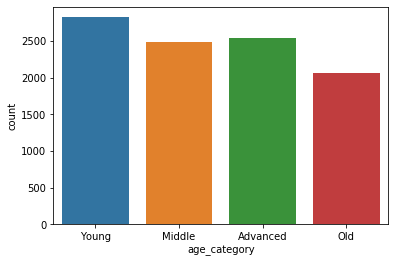

In [0]:
#plot of the age groups
print("This is a distribution of the number of lesions by Age Groups")
sns.countplot(x='age_category', data = df_new)
plt.show()

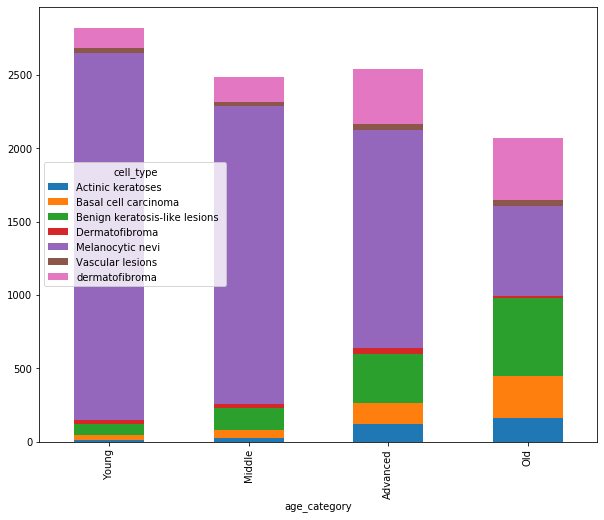

In [0]:
#Lesion prevalence in different age groups
df_new.groupby(['age_category', 'cell_type']).size().unstack().plot(kind='bar',stacked=True, figsize = (10,8))
plt.show()

You can see from the above plot that as age increases:
   1. The number of cases of Melanocytic nevi reduces
   2. The number of cases of Basa Cell Carcinoma, Dermatofibroma, Actinic Keratoses and Benign Keratosis-like lesions increase

This is the distribution of skin lesions' locations by age groups


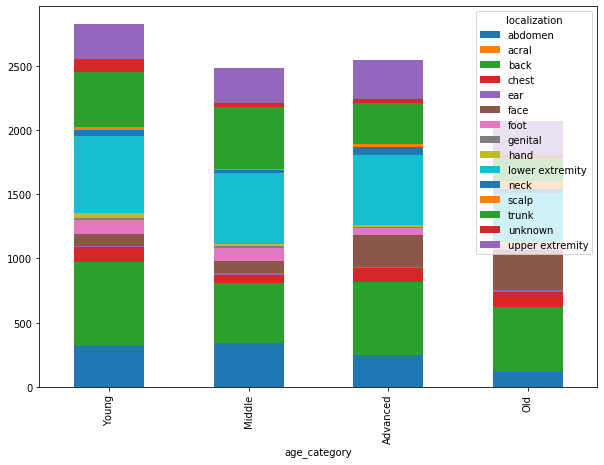

In [0]:
#Localization of lesions by age group
print("This is the distribution of skin lesions' locations by age groups")
df_new.groupby(['age_category', 'localization']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

You can see from the above graph that as age as agre increases from 'young' to 'old', the number of skin lesions found:


*   in the face increases
*   in the neck reduces

This could be useful in advising Dermatologists to pay more attention when examining for skin lesions based on age of the patient.


In [0]:
#profile report
pandas_profiling.ProfileReport(skin_df)

Number of variables,10
Number of observations,10015
Total Missing (%),0.1%
Total size in memory,714.1 KiB
Average record size in memory,73.0 B
Numeric,2
Categorical,6
Boolean,0
Date,0
Text (Unique),2
Rejected,0


In [0]:
print(skin_df.cell_type.value_counts())

Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


# More Visualizations

In [0]:
from plotnine import *
import plotly.express as px

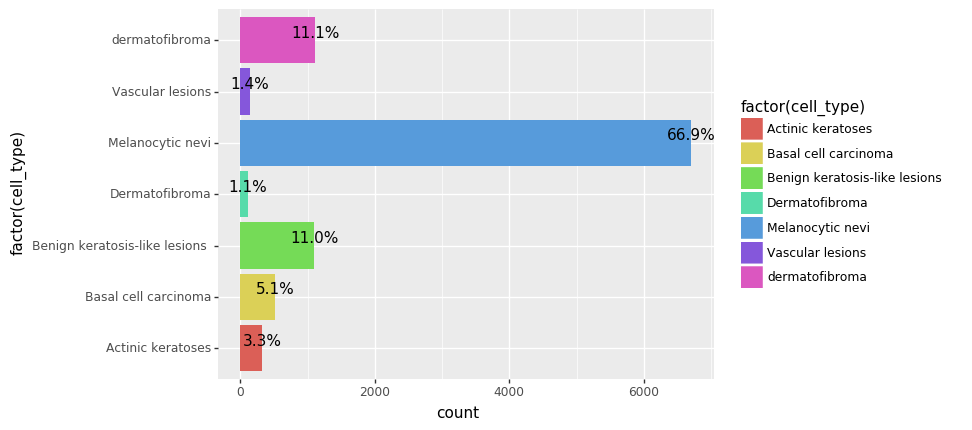

<ggplot: (8747996142179)>

In [0]:
#% distribution of lesions
p = (ggplot(skin_df, aes('factor(cell_type)', fill='factor(cell_type)'))
 + geom_bar()
 + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
)
p+coord_flip()


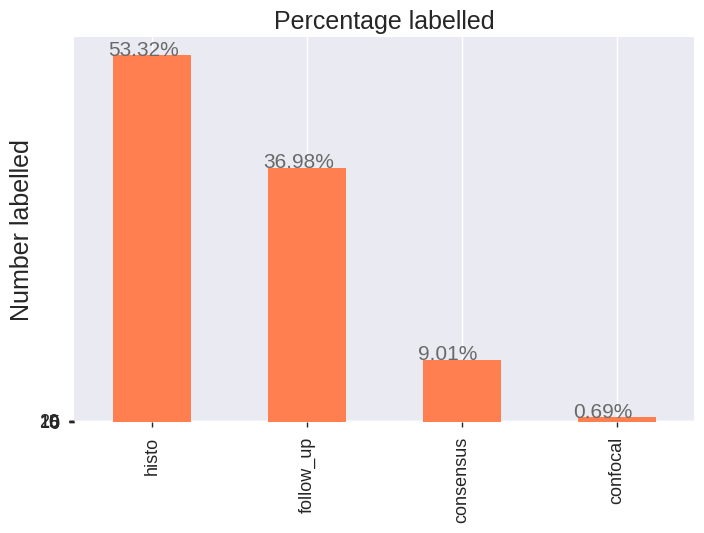

In [0]:
#Distribution of approach to labelling the data
ax = skin_df['dx_type'].value_counts().plot(kind='bar', figsize=(8,5),
                                        color="coral", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Percentage labelled", fontsize=18)
ax.set_ylabel("Number labelled", fontsize=18);
ax.set_yticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

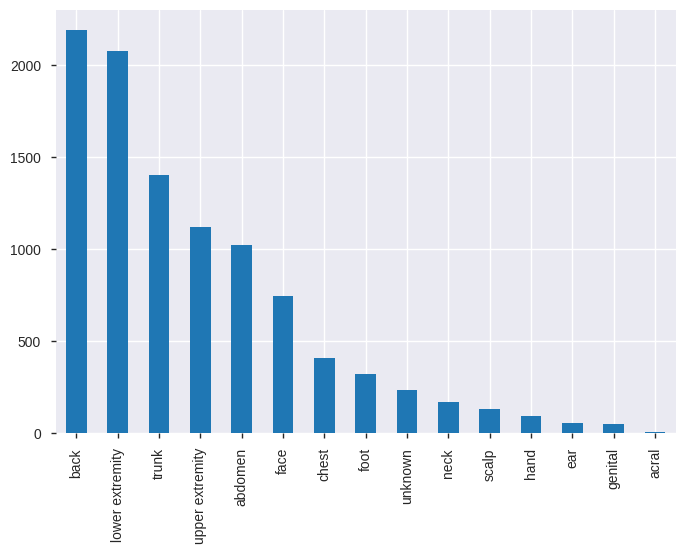

In [0]:
#Distribution of localization of lesions
skin_df['localization'].value_counts().plot(kind='bar')

In [0]:
#Animated visualization of localization by age
fig = px.bar(skin_df, x="localization", y="age", color="localization",
  animation_frame="dx_type", animation_group="cell_type", range_y=[0,3000])
fig.show()

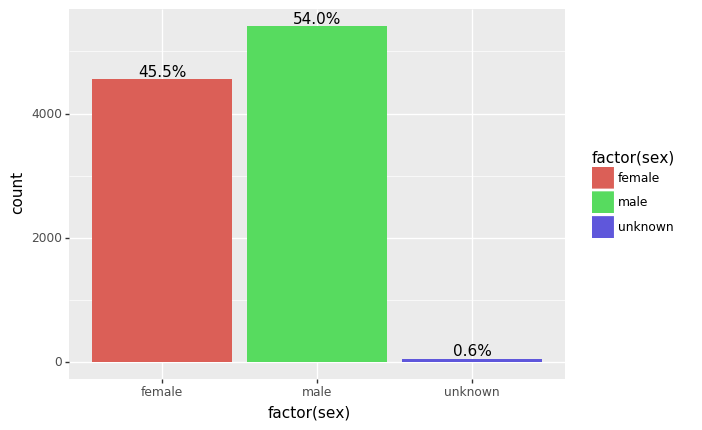

<ggplot: (8747996110540)>

In [0]:
#Distribution by sex
(ggplot(skin_df, aes('factor(sex)', fill='factor(sex)'))
 + geom_bar()
 + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
)

In [0]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/PROJECT/HAM10000_image...,Benign keratosis-like lesions,2


This is the distribution of different skin lesions by sex


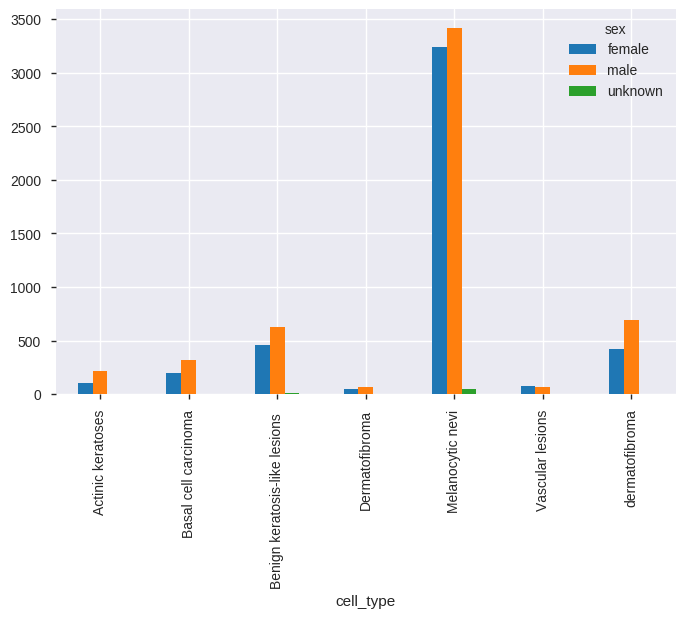

In [0]:
#lesion by sex
print("This is the distribution of different skin lesions by sex")
df_new.groupby(['cell_type', 'sex']).size().unstack().plot(kind='bar', stacked=False, figsize=(8,5))

# Modelling

In [0]:
# Load images  
# Resizing the original dimensions of 450 * 600 * 3 for ease of handling in tensorflow
%time
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


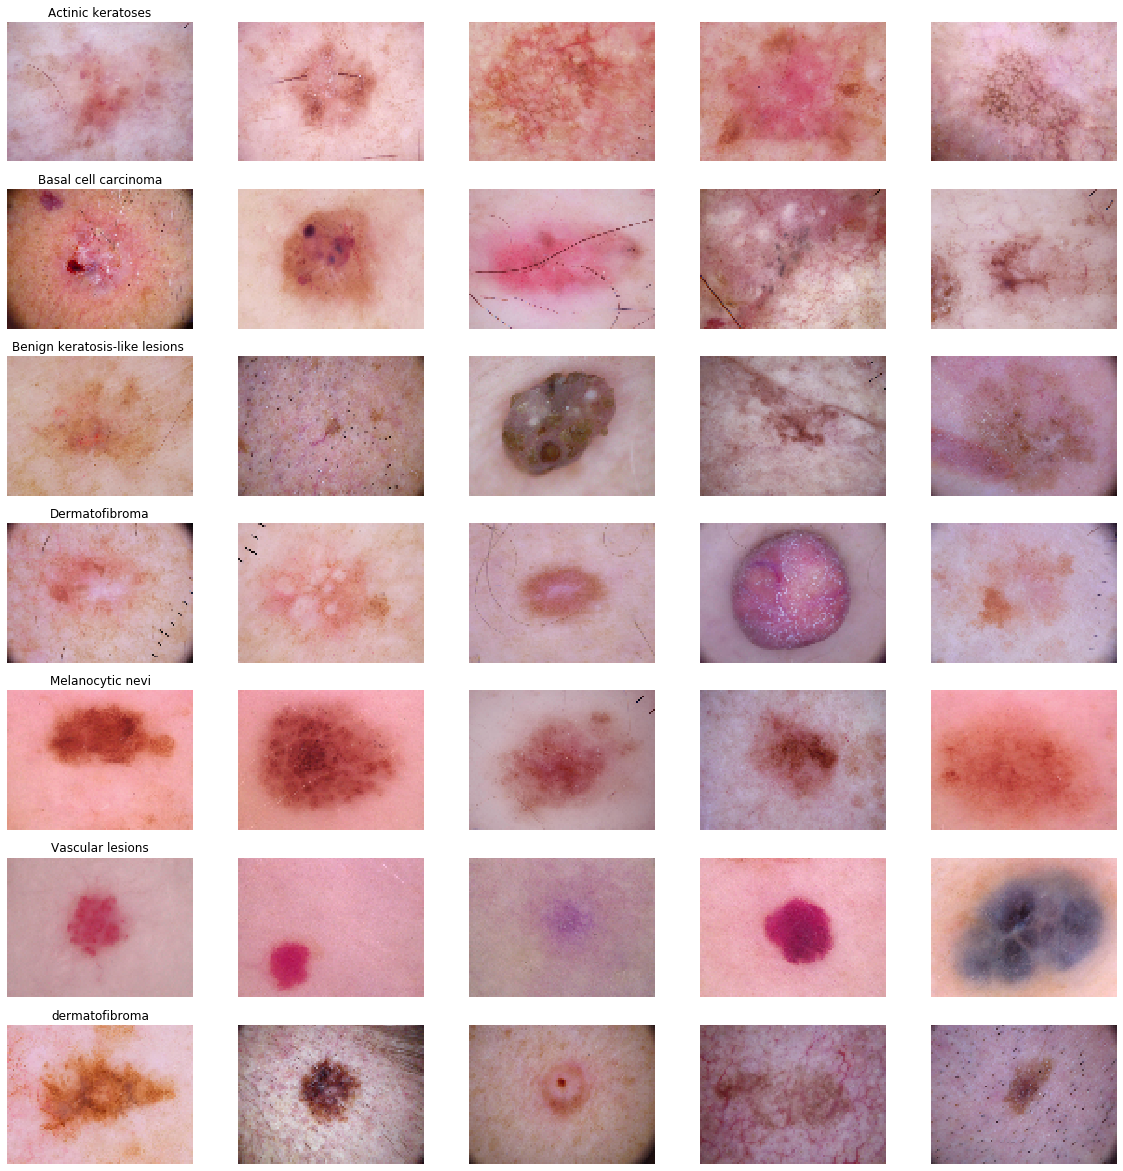

In [0]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [0]:
# See the image size distribution - should just return one row (all images are uniform)
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [0]:
#Color normalization as color samples vary across different types of skin diseases
rgb_info_df = skin_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
9539,1.110538,0.853659,1.035803,163.091956
4892,1.356864,0.805486,0.837649,162.976533
398,1.066815,0.963777,0.969408,171.611378
4124,1.295325,0.762554,0.942121,165.837067
8957,1.152993,0.919903,0.927104,158.872444
9661,1.074533,0.926067,0.999400,176.064089
9540,1.128453,0.843653,1.027894,157.599244
1909,1.110418,0.939186,0.950396,221.072844
5379,1.454946,0.806336,0.738719,149.599422
6872,1.090520,0.948680,0.960801,139.471733


In [0]:
for c in rgb_info_df.columns:
  skin_df[c] = rgb_info_df[c].values

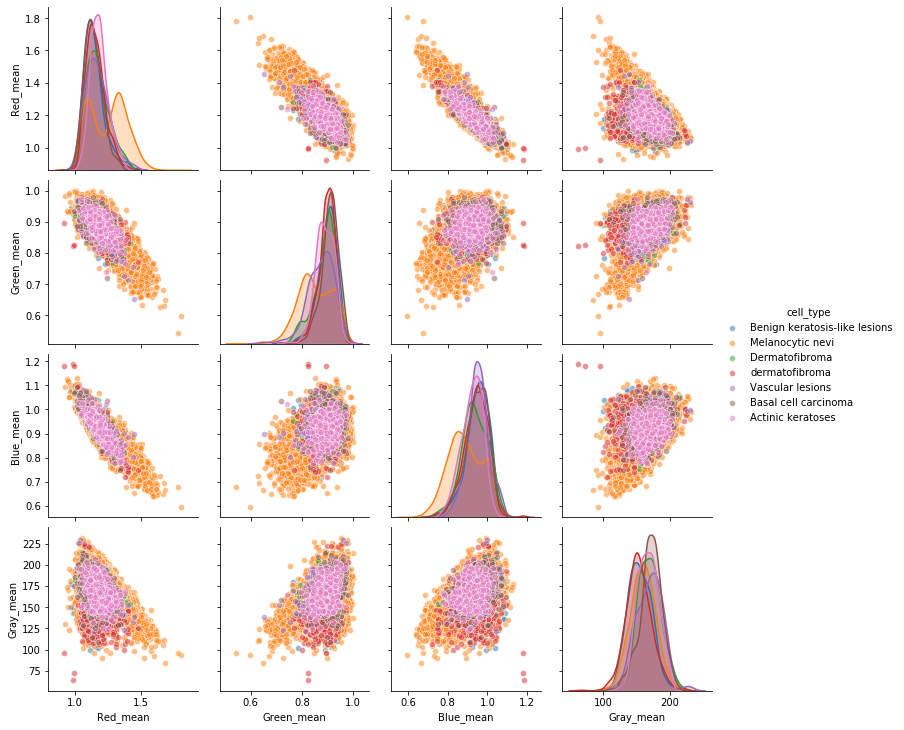

In [0]:
sns.pairplot(skin_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

In [0]:
#split
y = skin_df.cell_type_idx
X = skin_df.drop(['cell_type_idx'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y, test_size = 0.25, random_state=42)

In [0]:
#Convert to array
X_train = np.asarray(X_train_o['image'].tolist())
X_test = np.asarray(X_test_o['image'].tolist())

In [0]:
#Standardize manually
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_test_mean = np.mean(X_test)
X_test_std = np.std(X_test)

X_train_std = (X_train - X_train_mean)/X_train_std
X_test_std = (X_test - X_test_mean)/X_test_std

In [0]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

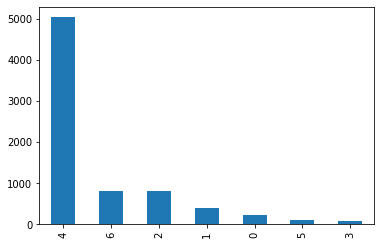

In [0]:
#Visualize encoded values:train
y_train_o.value_counts().plot(kind='bar')

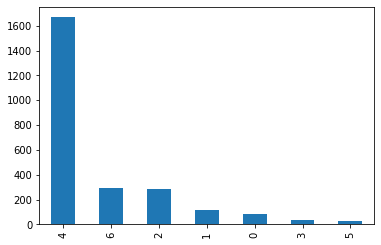

In [0]:
#Visualize encoded values: test
y_test_o.value_counts().plot(kind='bar')

In [0]:
#Compile model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(75,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 98, 16)        448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 49, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 36, 49, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 23, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 17, 23, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 21, 64)       

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
#Compiling the model using binary_crossentropy as the loss function and ADAM as the optimizer.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [0]:

#training the model using 100 epochs and also passing the validation data which we created earlier in order to validate the model’s performance:
history = model.fit(X_train_std, y_train, validation_split=0.3, epochs=50, verbose=0)

In [0]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_std, y_test, verbose=0)

In [0]:
print(loss)

0.2119264446865446


In [0]:
print(accuracy)

0.9267457994028402


In [0]:
print(f1_score)

0.7301214662984538


In [0]:
print(precision)

0.7694623226555772


In [0]:
print(recall)

0.6956869009584664


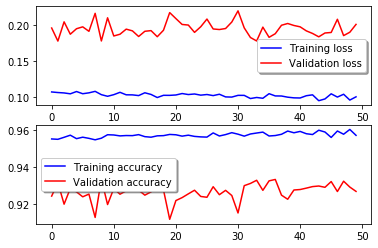

In [0]:
#plot of Training loss vs Validation loss
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

#plot of Training accuracy vs Validation accuracy
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)